In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torchsummary import summary

import easydict

from network_module import *


In [3]:
opt = easydict.EasyDict({
    "data_dir": '../dataset',
    "input_length": 220500,
    "image_height": 1025,
    "image_width": 431,
    "bbox_shape": 120,
    "mask_type": 'time_masking',
    "in_channels" : 2,
    "out_channels" : 1,
    "latent_channels" : 64,
    "pad_type": 'zero',
    "activation": 'lrelu',
    "norm":'in',
    "init_type":'xavier',
    "init_gain":0.02
    })

In [4]:
def weights_init(net, init_type = 'kaiming', init_gain = 0.02):
    """Initialize network weights.
    Parameters:
        net (network)       -- network to be initialized
        init_type (str)     -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_var (float)    -- scaling factor for normal, xavier and orthogonal.
    """
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and classname.find('Conv') != -1:
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain = init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a = 0, mode = 'fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain = init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, 0.02)
            init.constant_(m.bias.data, 0.0)
        elif classname.find('Linear') != -1:
            init.normal_(m.weight, 0, 0.01)
            init.constant_(m.bias, 0)

    # Apply the initialization function <init_func>
    net.apply(init_func)

#-----------------------------------------------
#                   Generator
#-----------------------------------------------
# Input: masked image + mask
# Output: filled image
class GatedGenerator(nn.Module):
    def __init__(self, opt):
        super(GatedGenerator, self).__init__()
        self.coarse = nn.Sequential(
            # encoder
            GatedConv2d(opt.in_channels, opt.latent_channels, 7, 1, 3, pad_type = opt.pad_type, activation = opt.activation, norm = 'none'),
            GatedConv2d(opt.latent_channels, opt.latent_channels * 2, 4, 2, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 2, opt.latent_channels * 4, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 4, 2, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            # Bottleneck
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 2, dilation = 2, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 4, dilation = 4, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 8, dilation = 8, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 16, dilation = 16, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            # decoder
            TransposeGatedConv2d(opt.latent_channels * 4, opt.latent_channels * 2, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 2, opt.latent_channels * 2, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            TransposeGatedConv2d(opt.latent_channels * 2, opt.latent_channels, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels, opt.out_channels, 7, 1, 3, pad_type = opt.pad_type, activation = 'none', norm = 'none')
        )
        self.refinement = nn.Sequential(
            # encoder
            GatedConv2d(opt.in_channels, opt.latent_channels, 7, 1, 3, pad_type = opt.pad_type, activation = opt.activation, norm = 'none'),
            GatedConv2d(opt.latent_channels, opt.latent_channels * 2, 4, 2, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 2, opt.latent_channels * 4, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 4, 2, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            # Bottleneck
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 2, dilation = 2, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 4, dilation = 4, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 8, dilation = 8, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 16, dilation = 16, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 4, opt.latent_channels * 4, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            # decoder
            TransposeGatedConv2d(opt.latent_channels * 4, opt.latent_channels * 2, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels * 2, opt.latent_channels * 2, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            TransposeGatedConv2d(opt.latent_channels * 2, opt.latent_channels, 3, 1, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm),
            GatedConv2d(opt.latent_channels, opt.out_channels, 7, 1, 3, pad_type = opt.pad_type, activation = 'none', norm = 'none')
        )
        
    def forward(self, img, mask):
        # img: entire img
        # mask: 1 for mask region; 0 for unmask region
        # 1 - mask: unmask
        # img * (1 - mask): ground truth unmask region
        # Coarse
        print(img.shape, mask.shape)
        first_masked_img = img * (1 - mask) + mask
        first_in = torch.cat((first_masked_img, mask), 1)       # in: [B, 4, H, W]
        first_out = self.coarse(first_in)                       # out: [B, 3, H, W]
        # Refinement
        second_masked_img = img * (1 - mask) + first_out * mask
        second_in = torch.cat((second_masked_img, mask), 1)     # in: [B, 4, H, W]
        second_out = self.refinement(second_in)                 # out: [B, 3, H, W]
        return first_out, second_out
    

#-----------------------------------------------
#                  Discriminator
#-----------------------------------------------
# Input: generated image / ground truth and mask
# Output: patch based region, we set 30 * 30
class PatchDiscriminator(nn.Module):
    def __init__(self, opt):
        super(PatchDiscriminator, self).__init__()
        # Down sampling
        self.block1 = Conv2dLayer(opt.in_channels, opt.latent_channels, 7, 1, 3, pad_type = opt.pad_type, activation = opt.activation, norm = 'none', sn = True)
        self.block2 = Conv2dLayer(opt.latent_channels, opt.latent_channels * 2, 4, 2, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm, sn = True)
        self.block3 = Conv2dLayer(opt.latent_channels * 2, opt.latent_channels * 4, 4, 2, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm, sn = True)
        self.block4 = Conv2dLayer(opt.latent_channels * 4, opt.latent_channels * 4, 4, 2, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm, sn = True)
        self.block5 = Conv2dLayer(opt.latent_channels * 4, opt.latent_channels * 4, 4, 2, 1, pad_type = opt.pad_type, activation = opt.activation, norm = opt.norm, sn = True)
        self.block6 = Conv2dLayer(opt.latent_channels * 4, 1, 4, 2, 1, pad_type = opt.pad_type, activation = 'none', norm = 'none', sn = True)
        
    def forward(self, img, mask):
        # the input x should contain 4 channels because it is a combination of recon image and mask
        x = torch.cat((img, mask), 1)
        x = self.block1(x)                                      # out: [B, 64, 256, 256]
        x = self.block2(x)                                      # out: [B, 128, 128, 128]
        x = self.block3(x)                                      # out: [B, 256, 64, 64]
        x = self.block4(x)                                      # out: [B, 256, 32, 32]
        x = self.block5(x)                                      # out: [B, 256, 16, 16]
        x = self.block6(x)                                      # out: [B, 256, 8, 8]
        return x

# ----------------------------------------
#            Perceptual Network
# ----------------------------------------
# VGG-16 conv4_3 features
class PerceptualNet(nn.Module):
    def __init__(self):
        super(PerceptualNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, 1, 1)
        )

    def forward(self, x):
        x = self.features(x)
        return x


In [5]:
generator = GatedGenerator(opt)
discriminator = PatchDiscriminator(opt)


In [11]:
summary(generator, [(1, 1024, 428), (1, 1024, 428)], device='cpu')

torch.Size([2, 1, 1024, 428]) torch.Size([2, 1, 1024, 428])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1         [-1, 2, 1030, 434]               0
            Conv2d-2        [-1, 64, 1024, 428]           6,336
            Conv2d-3        [-1, 64, 1024, 428]           6,336
           Sigmoid-4        [-1, 64, 1024, 428]               0
         LeakyReLU-5        [-1, 64, 1024, 428]               0
       GatedConv2d-6        [-1, 64, 1024, 428]               0
         ZeroPad2d-7        [-1, 64, 1026, 430]               0
            Conv2d-8        [-1, 128, 512, 214]         131,200
            Conv2d-9        [-1, 128, 512, 214]         131,200
          Sigmoid-10        [-1, 128, 512, 214]               0
   InstanceNorm2d-11        [-1, 128, 512, 214]               0
        LeakyReLU-12        [-1, 128, 512, 214]               0
      GatedConv2d-13        [-1, 128, 512, 

In [6]:
import torch
one = torch.ones([1])*0.581
test = []

In [7]:
test.append(one)

In [11]:
torch.mean(torch.tensor(test))

tensor(0.5810)

In [12]:
import torch
import librosa
import matplotlib.pyplot as plt
img = torch.ones(1, 2, 513, 431)
mask = torch.zeros(1, 1, 513, 431)

In [31]:
first_masked_img.shape

torch.Size([2, 513, 431])

In [38]:
first_out.shape

torch.Size([1, 2, 512, 428])

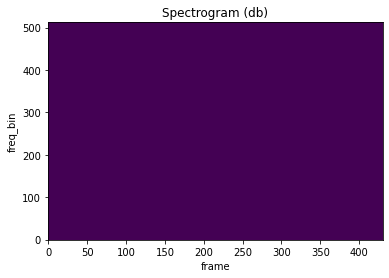

In [14]:
t = img[0,0,:,:]
fig, axs = plt.subplots(1, 1)
axs.set_title('Spectrogram (db)')
axs.set_ylabel('freq_bin')
axs.set_xlabel('frame')
im = axs.imshow(librosa.amplitude_to_db(t), origin='lower', aspect='auto')
if None:
    axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)

plt.savefig('test.png')